In [17]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, minmax_scale

from holodecml.data import get_dataset_path, load_scaled_datasets, load_raw_datasets, calc_z_bins

In [2]:
path_data = get_dataset_path()
num_particles = "large"
output_cols = ["x", "y", "z", "d", "hid"]
scaler_out = MinMaxScaler()
subset = False
num_z_bins = False
mass = False


In [3]:
train_inputs,\
train_outputs,\
valid_inputs,\
valid_outputs = load_scaled_datasets(path_data,
                                     num_particles,
                                     output_cols,
                                     scaler_out,
                                     subset,
                                     num_z_bins,
                                     mass)


In [4]:
print(train_inputs.shape)
print(train_outputs.shape)
print(valid_inputs.shape)
print(valid_outputs.shape)

(5000, 1200, 800, 1)
(5000, 100, 5)
(1000, 1200, 800, 1)
(1000, 100, 5)


In [8]:
# model_path = "/glade/p/cisl/aiml/ggantos/holodec/attention/"
model_path = "../../models/"
models = [f.path for f in os.scandir(model_path) if f.is_dir()]
models

['../../models/batch32',
 '../../models/base_80',
 '../../models/noisysd3',
 '../../models/noisysd4',
 '../../models/noisysd2',
 '../../models/base_40',
 '../../models/noisysd05',
 '../../models/sigmoid',
 '../../models/base']

In [9]:
models.sort()

In [15]:
from sklearn.metrics import mean_absolute_error, max_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

metrics = {"mae": mean_absolute_error,
           "rmse": rmse,
           "r2": r2,
           "max_error": max_error}


mae x:  0.080
mae y:  0.078
mae z:  0.079
mae d:  0.080
rmse x:  0.126
rmse y:  0.123
rmse z:  0.127
rmse d:  0.127
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


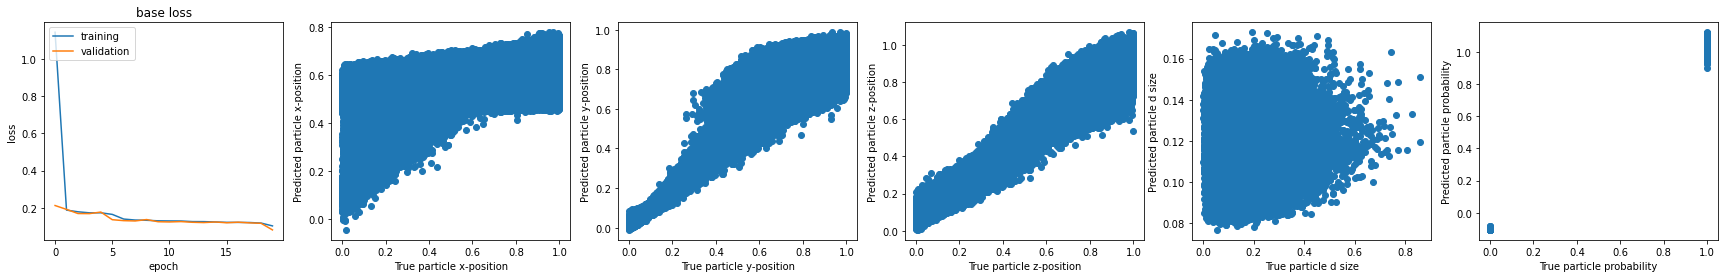

mae x:  0.043
mae y:  0.041
mae z:  0.042
mae d:  0.043
rmse x:  0.063
rmse y:  0.061
rmse z:  0.063
rmse d:  0.064
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


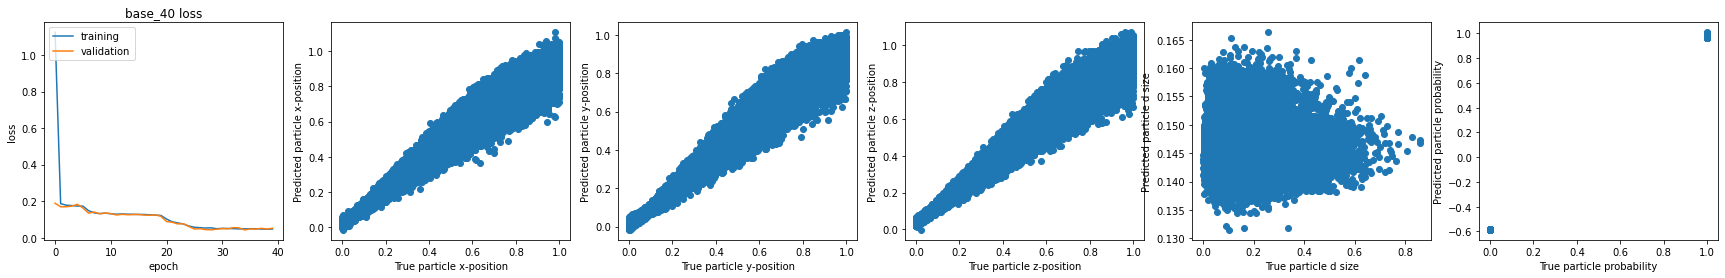

mae x:  0.040
mae y:  0.039
mae z:  0.039
mae d:  0.040
rmse x:  0.060
rmse y:  0.059
rmse z:  0.061
rmse d:  0.061
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


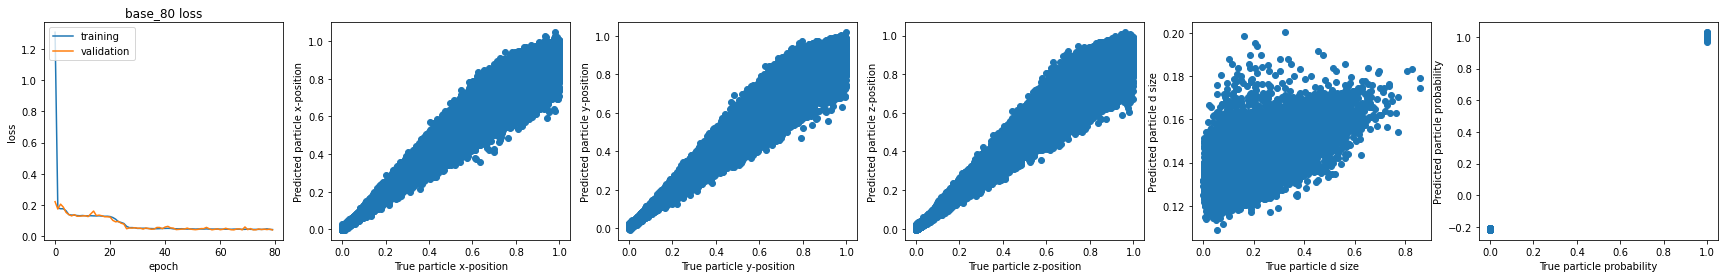

mae x:  0.045
mae y:  0.044
mae z:  0.045
mae d:  0.045
rmse x:  0.062
rmse y:  0.061
rmse z:  0.063
rmse d:  0.063
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


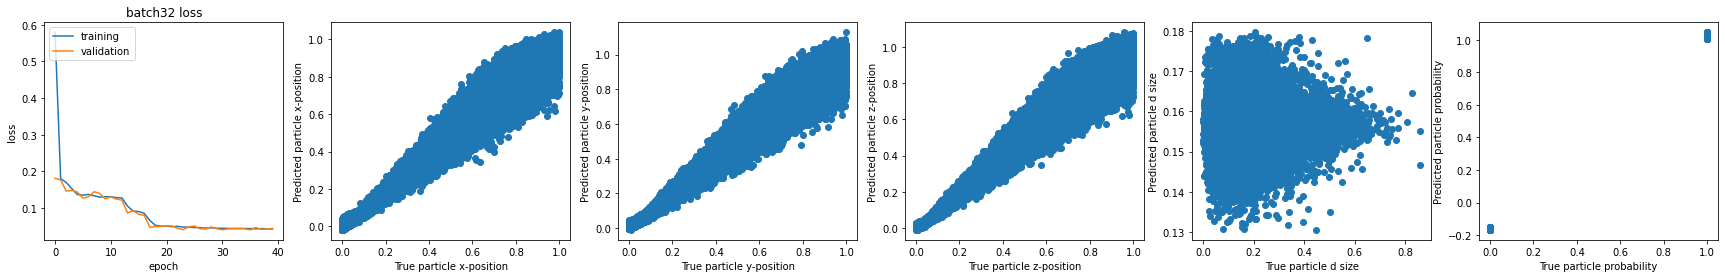

mae x:  0.030
mae y:  0.029
mae z:  0.030
mae d:  0.030
rmse x:  0.051
rmse y:  0.049
rmse z:  0.052
rmse d:  0.052
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


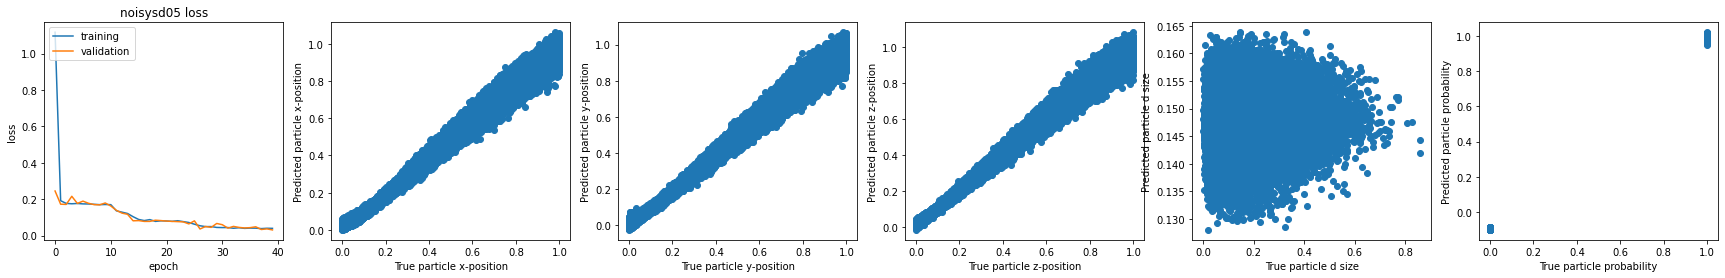

mae x:  0.061
mae y:  0.059
mae z:  0.060
mae d:  0.062
rmse x:  0.089
rmse y:  0.085
rmse z:  0.087
rmse d:  0.090
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


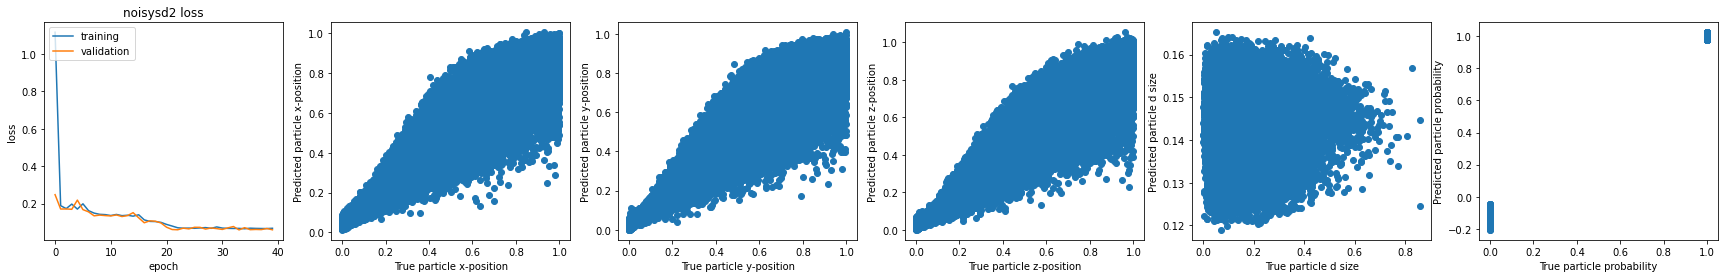

mae x:  0.082
mae y:  0.079
mae z:  0.080
mae d:  0.081
rmse x:  0.122
rmse y:  0.117
rmse z:  0.119
rmse d:  0.122
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


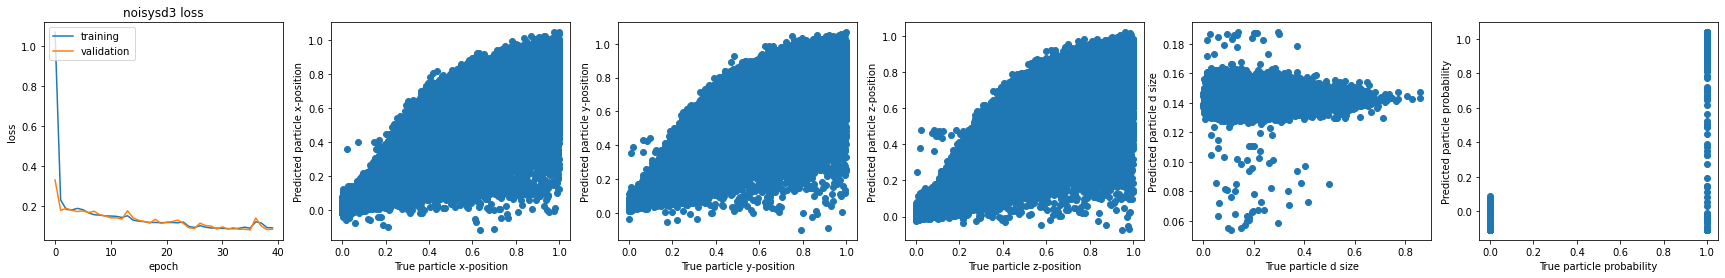

mae x:  0.166
mae y:  0.167
mae z:  0.166
mae d:  0.168
rmse x:  0.228
rmse y:  0.229
rmse z:  0.228
rmse d:  0.232
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


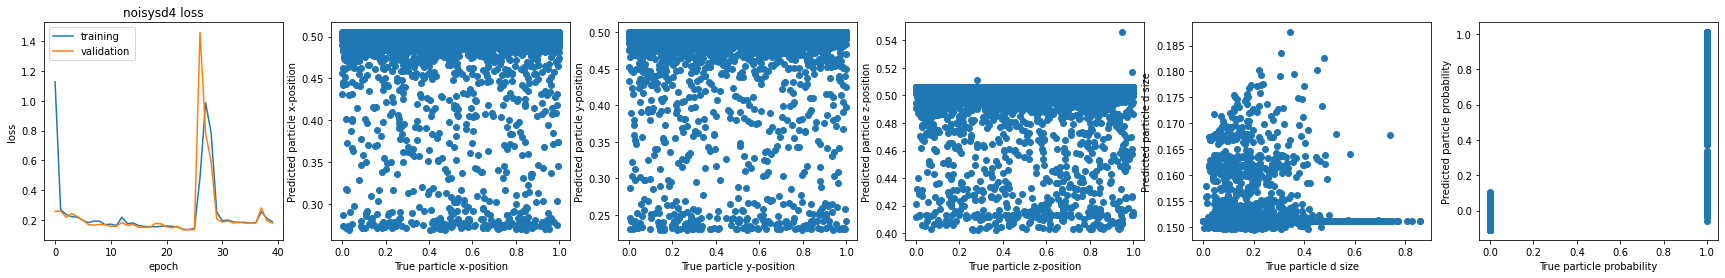

mae x:  0.171
mae y:  0.170
mae z:  0.170
mae d:  0.172
rmse x:  0.228
rmse y:  0.227
rmse z:  0.227
rmse d:  0.230
r2 x:  0.178
r2 y:  0.765
r2 z:  0.371
r2 d:  0.291


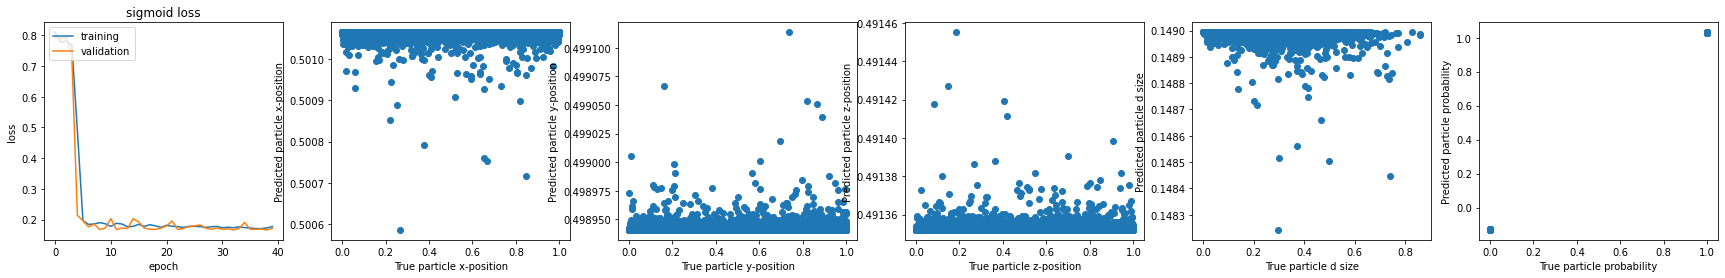

In [19]:
idx_true = valid_outputs[:,:,-1] > 0.5

for m in models:
    model = m[m.rfind('/')+1:]
    valid_outputs_pred = xr.open_dataset(os.path.join(model_path, model, "valid_outputs_pred.nc"))["valid_pred_scaled"].values
    
    scaled_scores = pd.DataFrame(0, index=["mae", "rmse", "r2"], columns=output_cols, dtype=np.float64)
    for metric in scaled_scores.index:
        for c, col in enumerate(output_cols[:-1]):
            scaled_scores.loc[metric, col] = metrics[metric](valid_outputs[:, c], valid_outputs_pred[:, c])
            print(f"{metric} {col}: {scaled_scores.loc[metric, col]: 0.3f}")
            
    loss = np.genfromtxt(os.path.join(model_path, model, "loss.csv"))
    val_loss = np.genfromtxt(os.path.join(model_path, model, "val_loss.csv"))
    
    fig, axes = plt.subplots(1, 6, figsize=(30, 4))
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_title(f'{model} loss')
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['training', 'validation'], loc='upper left')
    
    axes[1].scatter(valid_outputs[idx_true,0], valid_outputs_pred[idx_true,0])
    axes[1].set_xlabel("True particle x-position")
    axes[1].set_ylabel("Predicted particle x-position")
    
    axes[2].scatter(valid_outputs[idx_true,1], valid_outputs_pred[idx_true,1])
    axes[2].set_xlabel("True particle y-position")
    axes[2].set_ylabel("Predicted particle y-position")

    axes[3].scatter(valid_outputs[idx_true,2], valid_outputs_pred[idx_true,2])
    axes[3].set_xlabel("True particle z-position")
    axes[3].set_ylabel("Predicted particle z-position")

    axes[4].scatter(valid_outputs[idx_true,3], valid_outputs_pred[idx_true,3])
    axes[4].set_xlabel("True particle d size")
    axes[4].set_ylabel("Predicted particle d size")

    axes[5].scatter(valid_outputs[:,:,4].flatten(), valid_outputs_pred[:,:,4].flatten())
    axes[5].set_xlabel("True particle probability")
    axes[5].set_ylabel("Predicted particle probability")

    plt.savefig(f"transformer_prelim_results_{model}.png")
    plt.show()
    